<a href="https://colab.research.google.com/github/gopaps/MachineLearning/blob/main/week%2015/Anda_Figo_Haq_DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DETR in `transformers`
In this notebook, we going through a simple example of using pretrained `detr-resnet-50` to detect some objects in an image.

In [1]:
%pip install timm

In [2]:
# this example is mainly from https://huggingface.co/facebook/detr-resnet-50

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw
import requests

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

### Model
We are using `facebook/detr-resnet-50`, which is a basic DETR with a relatively small ResNet backbone. It has 100 object queries, which mean it can detect a maximum of 100 objects.

In [4]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Processor
The processor converts the image into a dict with keys `pixel_values` and `pixel_mask`. The pixel values are usually transformed in a manner that matches the paper implementation, which may involve normalization, resizing, etc.

In [5]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
inputs = processor(images=image, return_tensors="pt")

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

### Outputs
The output of the model is of type `DetrObjectDetectionOutput`, which contains `logits`, `last_hidden_states`, `pred_boxes`, etc. <br>
The size of `logits` is `(batch size, n_object_queries, n_classes)`, which is used to determine the classes of the detections. This model has 100 object queries and 92 classes. The object queries that have low confidences in classes, or have a "no object" class are filtered out in the `post_process_object_detection` function. <br>
The size of `pred_boxes` is `(batch size, n_object_queries, box_dimensions)`, which is used to determine the location of the bounding box.

In [6]:
outputs = model(**inputs)

In [7]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


In [8]:
img_draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    img_draw.rectangle(((box[0], box[1]),(box[2], box[3])), outline='Red')
    img_draw.text((box[0], box[1]), model.config.id2label[label.item()], align ="left")

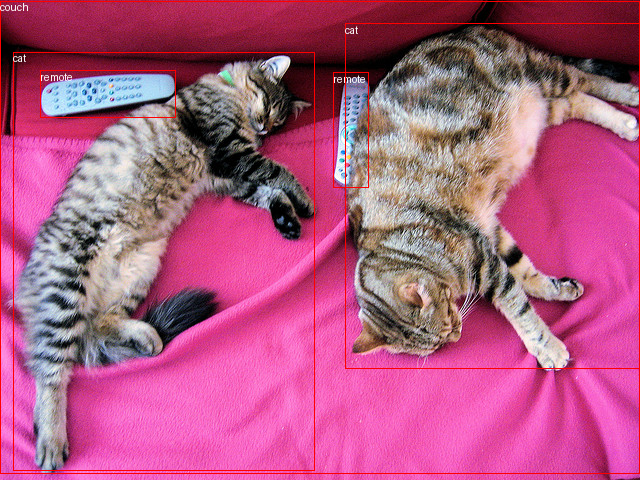

In [9]:
display(image)